In [87]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os


In [88]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [89]:
from masa_utils import PsuedoLog

In [90]:
parm_true = torch.tensor([np.log(200.), 0.5, np.log(0.01), 0.7], dtype=torch.float32, requires_grad=False)
parm_init = torch.tensor([np.log(100.), 0.1, np.log(0.001), 0.8], dtype=torch.float32, requires_grad=True)


In [91]:

# Define limits as torch tensors
reslim = torch.tensor(np.log([1e-1, 1e6]))
chglim = torch.tensor([1e-3, 0.9])
taulim = torch.tensor(np.log([1e-6, 1e-1]))
clim = torch.tensor([0.4, 1.0])

def clip_model(mvec):
    # Clone to avoid modifying the original tensor
    mvec_tmp = mvec.clone().detach()

    # Clip each parameter to its respective limit
    mvec_tmp[0] = torch.clamp(mvec[0], reslim.min(), reslim.max())
    mvec_tmp[1] = torch.clamp(mvec[1], chglim.min(), chglim.max())
    mvec_tmp[2] = torch.clamp(mvec[2], taulim.min(), taulim.max())
    mvec_tmp[3] = torch.clamp(mvec[3], clim.min(), clim.max())

    return mvec_tmp
def count_data_windows(times):
    count_data = torch.zeros_like(windows_strt)
    for i in range(nwindows):
        start = windows_strt[i]
        end = windows_end[i]
        ind_time = (times >= start) & (times <= end)
        count_data[i] = ind_time.sum()
    return count_data

def get_frequency_tau_window(log2min=-8, log2max=8):
    freqend = (1/tau)*2**log2max
    freqstep = (1/tau)*2**log2min
    freq = torch.arange(0,freqend,freqstep)
    times = torch.arange(0, 1/freqstep,1/freqend)
    count = count_data_windows(times)
    while count.min() < 2:
        log2max += 1
        freqend = (1/tau)*2**log2max
        if log2max > 15:
            print('No data windows can be created')
            break
        if count[windows_end==windows_end.max()] <2:
            log2min -= 1
            freqstep = (1/tau)*2**log2min
            if log2min < -15:
                print('No data windows can be created')
                break
        freq = torch.arange(0,freqend,freqstep)
        times = torch.arange(0, 1/freqstep,1/freqend)
        count = count_data_windows(times)
        print(count.min())
        print(freq[:4]) 
        print(times[:4])
    return freq, times

def pelton_res_f(p):
    """
    Pelton resistivity model made easy for PyTorch Auto Diffentiation.
    p[0] : log(res0)
    p[1] : eta
    p[2] : log(tau)
    p[3] : c
    """
    iwc = (1j * 2. * torch.pi * freq  ) ** p[3] 
    tc = torch.exp(-p[2]*p[3])
    f = torch.exp(p[0])*(tc +(1.0-p[1])*iwc)/(tc+iwc)
    return f

def pelton_con_f(p):
    """
    Pelton conductivity model made easy for PyTorch Auto Diffentiation.
    p[0] : log(con8)
    p[1] : eta
    p[2] : log(tau)
    p[3] : c
    """
    iwc = (1j * 2. * torch.pi * freq  ) ** p[3] 
    tc = torch.exp(-p[2]*p[3])
    f = torch.exp(p[0])*(1.0-p[1])*(tc +iwc)/(tc+(1.0-p[1])*iwc)
    return f

def freq_symmetric(f):
    f_sym = torch.zeros_like(f, dtype=torch.cfloat)
    nfreq = len(f)
    if nfreq  %2 == 0:
        nfreq2 = nfreq // 2
        f_sym[:nfreq2] = f[:nfreq2]
        f_sym[nfreq2] =f[nfreq2].real
        f_sym[nfreq2+1:] = torch.flip(f[1:nfreq2].conj(), dims=[0])

    # Ensure symmetry at the Nyquist frequency (if even length)
    else:
        nfreq2 = nfreq // 2 
        f_sym[:nfreq2+1] = f[:nfreq2+1]
        f_sym[nfreq2+1:] = torch.flip(f[1:nfreq2+1].conj(), dims=[0])
    return f_sym

def compute_fft(f):
    f_sym = freq_symmetric(f)
    t = torch.fft.ifft(f_sym) 
    return t

def compute_jacobian(parm):
    return torch.autograd.functional.jacobian(dpred, parm)

def pelton_res_f_grad(p):
    res = torch.exp(p[0])
    chg = p[1]
    tau = torch.exp(p[2])
    c = p[3]

    nfreq = len(freq)
    iwt = 1j * 2. * torch.pi * freq * tau
    iwc = 1j * 2. * torch.pi*  freq * c
    iwtc = iwt ** c

    # Initialize gradient as a complex tensor
    grad = torch.zeros((4, nfreq), dtype=torch.cfloat)

    # Derivative with respect to res0
    # grad[0] = 1 - p[1] * (1 - 1. / (1. + iwtc))
    # grad[1] = -p[0] * (1 - 1. / (1. + iwtc))
    grad[0] = 1 - chg * (1 - 1. / (1. + iwtc))
    grad[0] *= res
    grad[1] = -res* (1 - 1. / (1. + iwtc))

    # Derivatives with respect to tau and c
    if p[1] != 0:
        # grad[2] = p[0] * p[1] * (-iwc * iwt ** (p[3] - 1) / (1. + iwtc) ** 2)
        # grad[3] = p[0] * p[1] * (-iwtc * torch.log(iwt) / (1. + iwtc) ** 2)
        grad[2] = res * chg * (-iwc * iwt ** (c - 1) / (1. + iwtc) ** 2)
        grad[2] *= tau
        grad[3] = res * chg * (-iwtc * torch.log(iwt) / (1. + iwtc) ** 2)

        # Handle zero frequency case to avoid NaN/Inf
        grad[2, freq == 0] = 0 + 0j
        grad[3, freq == 0] = 0 + 0j
    else:
        grad[2] = torch.zeros(nfreq, dtype=torch.cfloat)
        grad[3] = torch.zeros(nfreq, dtype=torch.cfloat)
    grad_real = grad.real.T.reshape(-1, 4)
    grad_imag = grad.imag.T.reshape(-1, 4)

    return torch.cat([grad_real, grad_imag], dim=0)

def get_windows( times):
    windows_strt = torch.zeros_like(times)
    windows_end =torch.zeros_like(times)
    dt = torch.diff(times)
    windows_strt[1:] = times[:-1] + dt / 2
    windows_end[:-1] = times[1:] - dt / 2
    windows_strt[0] = times[0] - dt[0] / 2
    windows_end[-1] = times[-1] + dt[-1] / 2
    return windows_strt,windows_end

def get_window_matrix (times, windows_strt=None, windows_end=None):
    # windows_strt = self.get_param(windows_strt, self.windows_strt)
    # windows_end = self.get_param(windows_end, self.windows_end)
    # self.validate_times(times)
    nwindows = len(windows_strt)
    window_matrix = torch.zeros((nwindows, len(times)))
    for i in range(nwindows):
        start = windows_strt[i]
        end = windows_end[i]
        ind_time = (times >= start) & (times <= end)
        if ind_time.sum() > 0:
            window_matrix[i, ind_time] = 1/ind_time.sum()
    return window_matrix    

def dpred(p):
#    freq ,times = get_frequency_tau_window()
    f = pelton_res_f(p)
    t = compute_fft(f)
    t_real = t.real
    data = window_mat@t_real 
    return data

def dpred_f(p):
    f = pelton_res_f(p)
    f_real = f.real
    f_imag = f.imag
    data = torch.cat([window_mat@f_real, window_mat@f_imag])
    return data

def compute_jacobian(parm):
    return torch.autograd.functional.jacobian(dpred, parm)

def loss_fn(parm):
    r = dpred(parm)-dobs
    r = Wd @ r
    # return r.sum()
    return 0.5 * torch.dot(r,r)

def compute_hessian(parm):
    hessian = torch.autograd.functional.hessian(loss_fn, parm)
    return hessian

def compute_gradient(parm):
    grad = torch.autograd.functional.jacobian(loss_fn, parm)
    return grad

def get_Wd(dobs, ratio=0.10, plateau=0):
    dobs_clone = dobs.clone().detach()
    noise_floor = plateau * torch.ones_like(dobs_clone)
    std = torch.sqrt(noise_floor**2 + (ratio * torch.abs(dobs_clone))**2)
    Wd = torch.diag(1 / std.flatten())
    Wd =Wd
    return Wd

def GaussNewton(dobs, mvec_init, niter, 
    s0=torch.tensor(1.0), sfac = torch.tensor(0.5), 
    stol=torch.tensor(1e-6), gtol=torch.tensor(1e-3), mu=torch.tensor(1e-4)):
    mvec_old = mvec_init.clone().detach().requires_grad_(True)

#    mvec_old = mvec_init
    f_old = loss_fn(mvec_old)

    error_prg = torch.zeros(niter + 1)
    mvec_prg = torch.zeros((niter + 1, mvec_init.shape[0]))
    error_prg[0] = f_old
    mvec_prg[0, :] = mvec_old.detach()

    for i in range(niter):
        rd = Wd@(dpred(mvec_old) - dobs)
        # rd = (dpred(mvec_old) - dobs)
        # J = pelton_res_f_grad(mvec_old)
        J = compute_jacobian(mvec_old)
        g = J.T @ Wd.T@ rd
        H = J.T @ Wd.T@ Wd@J
        
        dm = torch.linalg.solve(H, g).flatten()  # Ensure dm is a 1D tensor

        g_norm = torch.linalg.norm(g, ord=2)

        if g_norm < gtol:
            print(f"Inversion complete since norm of gradient is small as: {g_norm:.3e}")
            break

        s = s0
        mvec_new = clip_model(mvec_old - s * dm)
        f_new = loss_fn(mvec_new)# phid
        directional_derivative = torch.dot(g.flatten(), -dm.flatten())
        while f_new >= f_old + s * mu * directional_derivative:
            s *= sfac
            mvec_new = clip_model(mvec_old - s * dm)
            f_new = loss_fn(mvec_new) #phid
            if s < stol:
                break

        mvec_old = mvec_new
        mvec_prg[i + 1, :] = mvec_new
        f_old = f_new
        error_prg[i + 1] = f_new
        print(f'{i + 1:3}, step:{s:.1e}, gradient:{g_norm:.1e},  f:{f_new:.1e}')

    error_prg = error_prg[:i + 2]
    mvec_prg = mvec_prg[:i + 2]
    return mvec_new.detach(), mvec_prg


In [92]:
tau=torch.tensor(1e-3)

In [93]:
nfreq =  2**16
freqcen = 1e3

#freqcen = 1 / torch.exp(parm_true[2]).detach()
freqend = freqcen * nfreq**0.5
freqstep = freqend / nfreq
freq = torch.arange(0, freqend, freqstep)
times = torch.arange(0, 1 / freqstep, 1 / freqend)
print(freq.shape)
print(torch.exp(parm_true[2]), freqstep, freqend)
print(freq[-1])


torch.Size([65536])
tensor(0.0100) 3.90625 256000.0
tensor(255996.0938)


In [94]:
nwindows = 15 +2 
time_window = torch.cat([torch.tensor([0.0]),torch.logspace(-4,-2.5,nwindows-1)])
print(time_window)
windows_strt, windows_end = get_windows(time_window)
tau = 1e-3
count = count_data_windows(times)
print(count_data_windows(times).min())
print(count)

tensor([0.0000e+00, 1.0000e-04, 1.2589e-04, 1.5849e-04, 1.9953e-04, 2.5119e-04,
        3.1623e-04, 3.9811e-04, 5.0119e-04, 6.3096e-04, 7.9433e-04, 1.0000e-03,
        1.2589e-03, 1.5849e-03, 1.9953e-03, 2.5119e-03, 3.1623e-03])
tensor(8.)
tensor([ 13.,  16.,   8.,   9.,  12.,  15.,  19.,  24.,  29.,  38.,  47.,  60.,
         75.,  94., 118., 150., 166.])


In [95]:
print(get_frequency_tau_window())
print(count_data_windows(times))

(tensor([0.0000e+00, 3.9062e+00, 7.8125e+00,  ..., 2.5599e+05, 2.5599e+05,
        2.5600e+05]), tensor([0.0000e+00, 3.9063e-06, 7.8125e-06,  ..., 2.5599e-01, 2.5599e-01,
        2.5600e-01]))
tensor([ 13.,  16.,   8.,   9.,  12.,  15.,  19.,  24.,  29.,  38.,  47.,  60.,
         75.,  94., 118., 150., 166.])


In [96]:
window_mat = get_window_matrix(times=times, windows_strt=windows_strt, windows_end=windows_end)

In [97]:
f= pelton_res_f(parm_init)
# f= pelton_res_f(parm_true)
print(f.shape)
print(f.real)
print(f.imag)


torch.Size([65536])
tensor([100.0000,  99.8205,  99.6637,  ...,  90.0085,  90.0085,  90.0085],
       grad_fn=<SelectBackward0>)
tensor([ 0.0000, -0.4736, -0.8021,  ..., -0.0258, -0.0258, -0.0258],
       grad_fn=<SelectBackward0>)


In [98]:
f_sym = freq_symmetric(f)
nfreq2 = nfreq // 2
print(f_sym.real)
print(f_sym.imag)
print(f_sym[nfreq//2-1:nfreq//2+2])

tensor([100.0000,  99.8205,  99.6637,  ...,  99.5080,  99.6637,  99.8205],
       grad_fn=<SelectBackward0>)
tensor([ 0.0000, -0.4736, -0.8021,  ...,  1.0805,  0.8021,  0.4736],
       grad_fn=<SelectBackward0>)
tensor([90.0148-0.0449j, 90.0148+0.0000j, 90.0148+0.0449j],
       grad_fn=<SliceBackward0>)


In [99]:

# Inverse FFT - retain complex result
t = torch.fft.ifft(f_sym) 
dest = t.real
print(dest[0])
print(dest.sum())
print(dest[1:].sum()/dest.sum())
print(dest)


tensor(90.0729, grad_fn=<SelectBackward0>)
tensor(100.0000, grad_fn=<SumBackward0>)
tensor(0.0993, grad_fn=<DivBackward0>)
tensor([ 9.0073e+01,  1.1412e-01,  7.8989e-02,  ..., -4.5693e-03,
         6.6636e-03, -1.2127e-02], grad_fn=<SelectBackward0>)


# Set parametr

In [100]:
parm_true = torch.tensor([np.log(0.1), 0.5, np.log(0.001), 0.6], dtype=torch.float32, requires_grad=False)
parm_init = torch.tensor([np.log(1.0), 0.1, np.log(0.003), 0.7], dtype=torch.float32, requires_grad=True)


In [101]:
relative_error = 0.10
noise_floor =  0#0.0
dinit = dpred(parm_init)

dobs_clean = dpred(parm_true)
Wd = get_Wd(dobs_clean, ratio=relative_error, plateau=noise_floor)

In [102]:
torch.random.seed()
dobs = ( dobs_clean
    + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + noise_floor*torch.ones(len(dobs_clean))**2
    )
    )

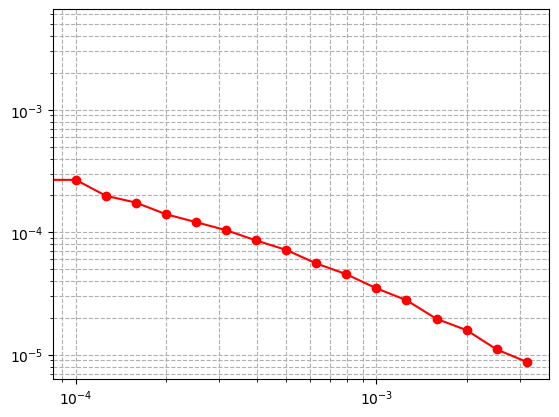

In [103]:
plt.loglog(time_window,abs(dobs), linestyle='-', marker='o', color='r')
plt.grid(True, which="both", ls="--")

In [104]:
print(loss_fn(parm_init))
print(dobs-dinit)

tensor(11491.0449, grad_fn=<MulBackward0>)
tensor([-6.4849e-02, -8.6412e-07, -2.2938e-05, -2.6578e-05, -4.1468e-05,
        -4.2257e-05, -4.1926e-05, -4.3527e-05, -4.2064e-05, -4.3642e-05,
        -4.0163e-05, -3.7985e-05, -3.3262e-05, -3.0923e-05, -2.5247e-05,
        -2.1734e-05, -1.7215e-05], grad_fn=<SubBackward0>)


# Jacobian?

In [105]:
#jacobian = torch.autograd.functional.jacobian(dpred, parm)
jacobian = compute_jacobian(parm_init)
print(jacobian.shape)
print(jacobian)

torch.Size([17, 4])
tensor([[ 6.9691e-02, -7.2323e-02, -3.0920e-04, -1.9077e-03],
        [ 2.6876e-04,  2.6876e-03, -1.6713e-04, -5.1895e-04],
        [ 2.2160e-04,  2.2159e-03, -1.3095e-04, -2.8670e-04],
        [ 2.0132e-04,  2.0132e-03, -1.1524e-04, -2.0140e-04],
        [ 1.8189e-04,  1.8189e-03, -1.0021e-04, -1.2590e-04],
        [ 1.6327e-04,  1.6327e-03, -8.5816e-05, -6.2249e-05],
        [ 1.4596e-04,  1.4596e-03, -7.2491e-05, -1.2203e-05],
        [ 1.2926e-04,  1.2926e-03, -5.9803e-05,  2.9203e-05],
        [ 1.1384e-04,  1.1384e-03, -4.8316e-05,  5.9511e-05],
        [ 9.9335e-05,  9.9336e-04, -3.7808e-05,  8.0234e-05],
        [ 8.5616e-05,  8.5616e-04, -2.8260e-05,  9.2752e-05],
        [ 7.2877e-05,  7.2877e-04, -1.9875e-05,  9.7694e-05],
        [ 6.1153e-05,  6.1153e-04, -1.2717e-05,  9.5978e-05],
        [ 5.0579e-05,  5.0579e-04, -6.8838e-06,  8.8916e-05],
        [ 4.1135e-05,  4.1135e-04, -2.3401e-06,  7.8074e-05],
        [ 3.2795e-05,  3.2795e-04,  9.7967e-07,  6

In [106]:
# J_ana = pelton_res_f_grad(parm_init)
# print(J_ana)

# Gauss-Newton

In [107]:
niter = 25
mpred, mvec_prg = GaussNewton(dobs=dobs,mvec_init=parm_init,niter=niter)


  1, step:1.0e+00, gradient:2.9e+04,  f:1.3e+03
  2, step:1.0e+00, gradient:4.1e+03,  f:1.6e+02
  3, step:1.0e+00, gradient:1.6e+03,  f:1.8e+01
  4, step:1.0e+00, gradient:5.9e+02,  f:1.1e+00
  5, step:1.0e+00, gradient:1.2e+02,  f:5.2e-01
  6, step:1.0e+00, gradient:1.4e+00,  f:5.2e-01
Inversion complete since norm of gradient is small as: 8.234e-05


In [108]:
np_mvec_prg = mvec_prg.detach().numpy()
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = dpred(mpred)
print(f"initial :{np.exp(np_mvec_init[0]):.3e}, {np_mvec_init[1]:3f}, {np.exp(np_mvec_init[2]):.3e}, {np_mvec_init[3]:.3f}")
print(f"estimate:{np.exp(np_mvec_est[0]):.3e}, { np_mvec_est[1]:3f}, { np.exp(np_mvec_est[2]):.3e}, { np_mvec_est[3]:.3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.3e}, {np_mvec_true[1]:3f}, {np.exp(np_mvec_true[2]):.3e}, {np_mvec_true[3]:.3f}")


initial :1.000e+00, 0.100000, 3.000e-03, 0.700
estimate:1.064e-01, 0.483658, 1.015e-03, 0.615
true    :1.000e-01, 0.500000, 1.000e-03, 0.600


In [109]:

print(mvec_prg)

tensor([[ 0.0000,  0.1000, -5.8091,  0.7000],
        [-0.8825,  0.1506, -5.9636,  0.5632],
        [-1.6316,  0.2328, -6.9702,  0.5784],
        [-2.0876,  0.3684, -6.8625,  0.6212],
        [-2.2294,  0.4673, -6.8955,  0.6140],
        [-2.2405,  0.4835, -6.8927,  0.6150],
        [-2.2406,  0.4837, -6.8928,  0.6150],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<SliceBackward0>)


# Plot

In [110]:
dest_plot = dest.detach().numpy().flatten()
dobs_plot = dobs.detach().numpy().flatten()
dinit_plot = dinit.detach().numpy().flatten()
windows_plot = time_window.detach().numpy()

In [111]:
jacobian = compute_jacobian(mpred)
WdJ = Wd@jacobian
j_plot = WdJ.detach().numpy()
print(j_plot.shape)
tau_plot = np.exp(mpred[2].detach().numpy())

(17, 4)


In [112]:
PL_pelton = PsuedoLog(
            logmin=1e-6,
            linScale=0.5,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)
PL_jac = PsuedoLog(
            logmin=1e1,
            linScale=0.5,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)

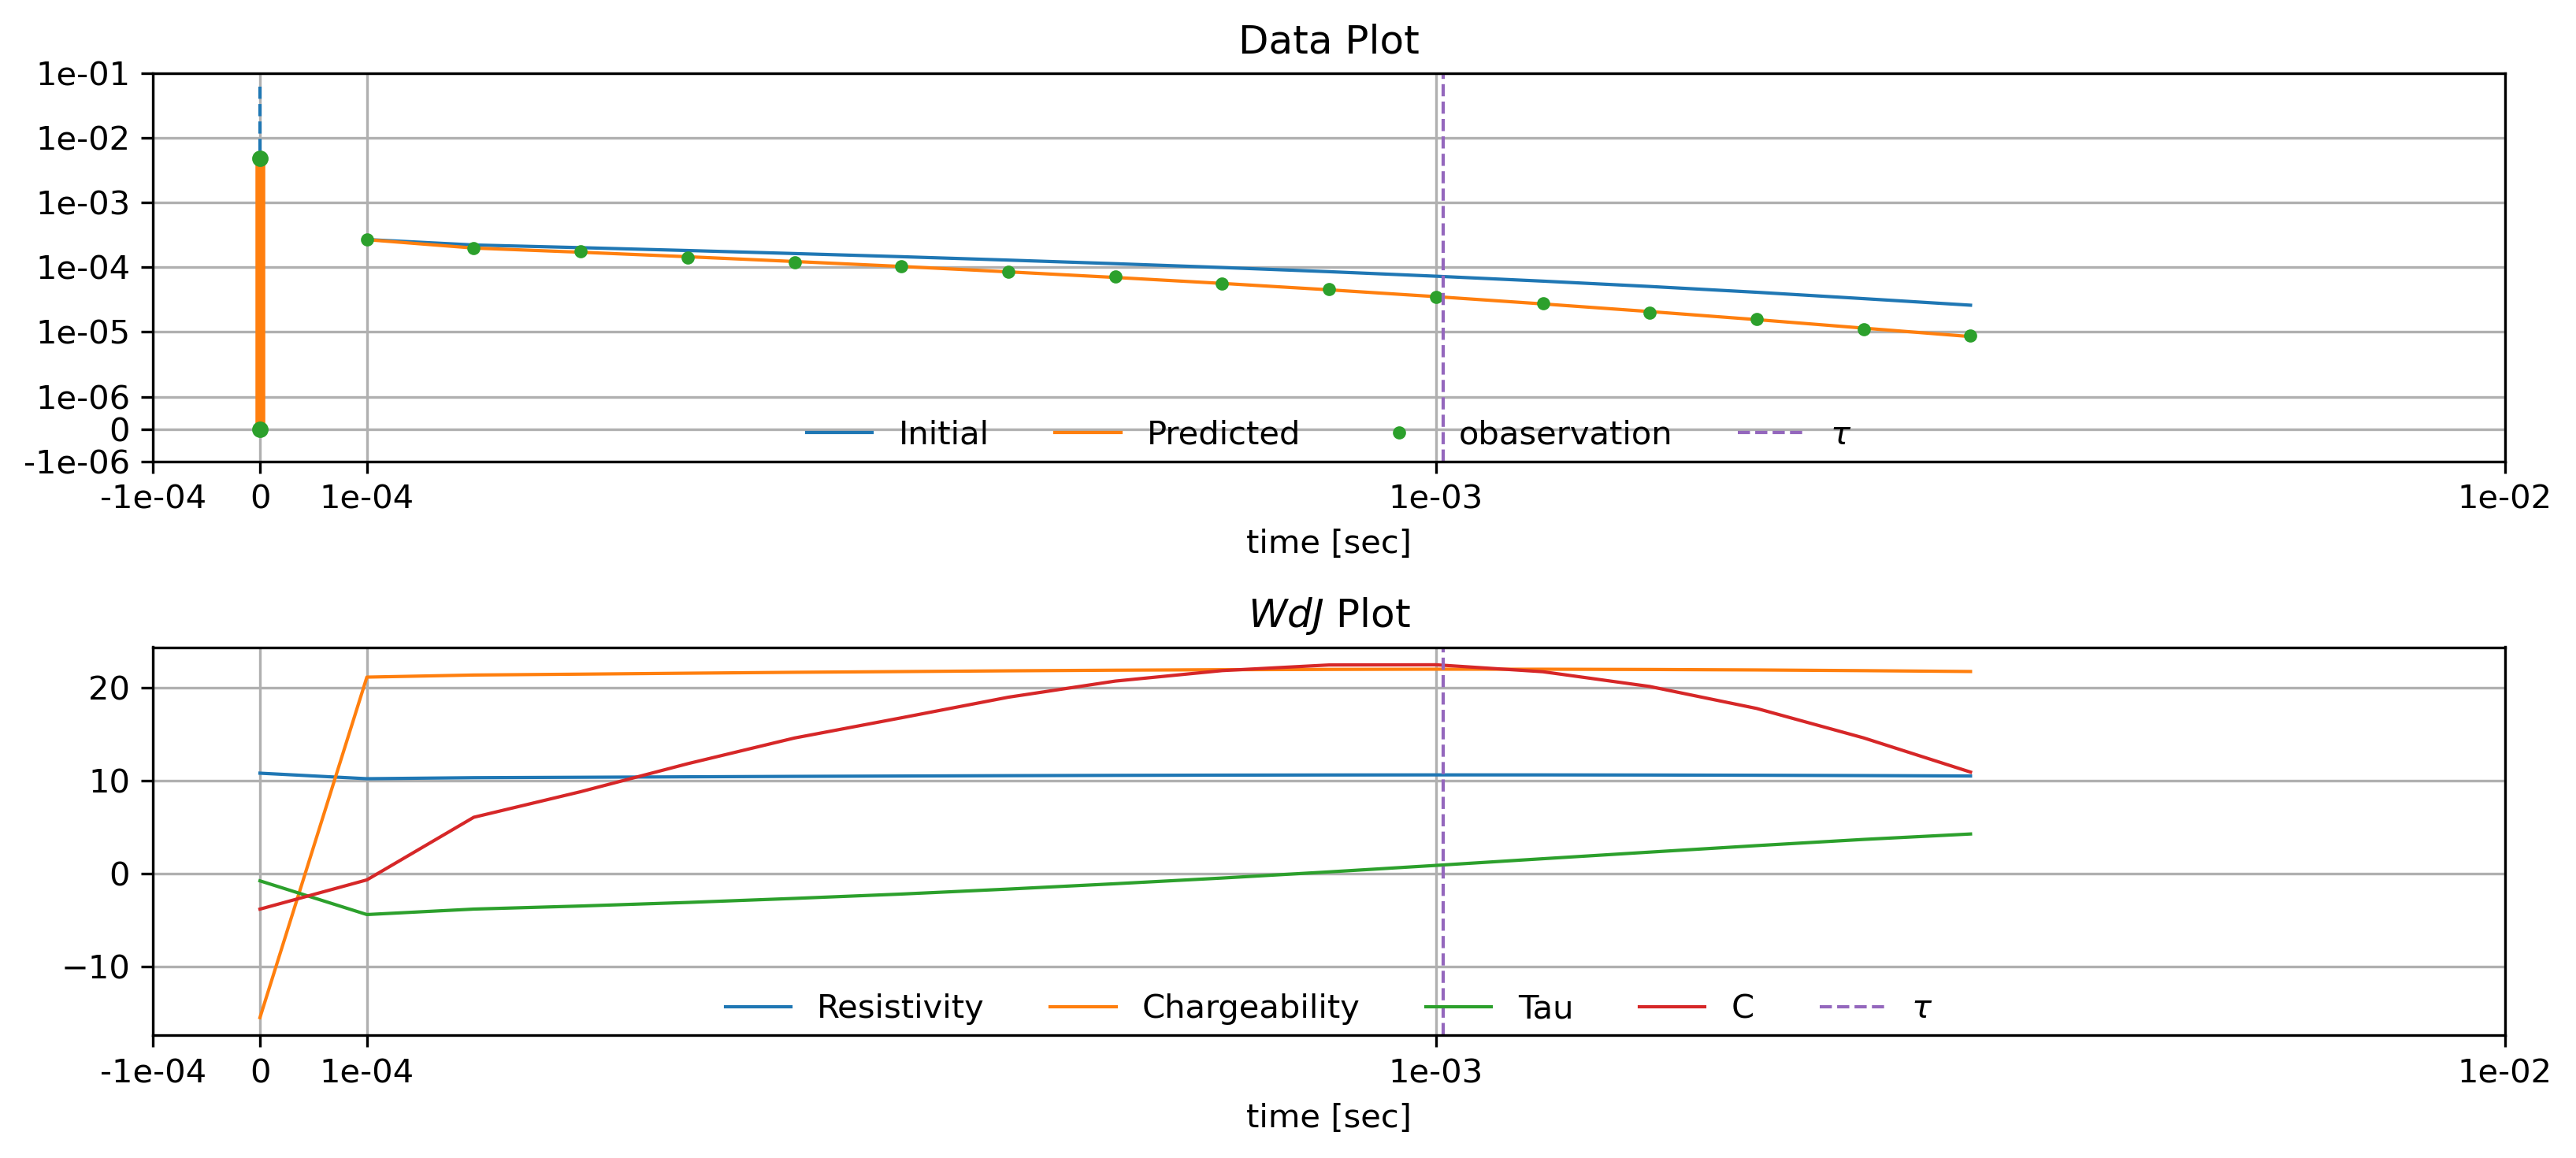

In [113]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0] = PL_pelton.plpl_plot(x=np.r_[0,0], y=np.r_[0,dinit_plot[0]], ax=ax[0],
                          color = "C0",linestyle="--")
ax[0] = PL_pelton.plpl_plot(x=windows_plot[1:], y=dinit_plot[1:], ax=ax[0],
                          color = "C0",label="Initial")
ax[0] = PL_pelton.plpl_plot(x=np.r_[0,0], y=np.r_[0,dest_plot[0]], ax=ax[0],
                                color = "C1", linewidth=3.0)
ax[0] = PL_pelton.plpl_plot(x=windows_plot[1:], y=dest_plot[1:], ax=ax[0],
                            color = "C1",label="Predicted")
ax[0] = PL_pelton.plpl_plot(x=np.r_[0,0], y=np.r_[0,dobs_plot[0]], ax=ax[0],
                                color = "C2",linestyle="", marker="o",markersize= 4)
ax[0] = PL_pelton.plpl_plot(x=windows_plot, y=dobs_plot, ax=ax[0], 
                            color = "C2",linestyle="", marker="o",markersize= 3,label="obaservation")
ax[0] = PL_pelton.pl_axvline(ax=ax[0], x=tau_plot, color="C4",label=r'$\tau$')
PL_pelton.pl_axes_x(ax=ax[0])
PL_pelton.pl_axes(ax=ax[0])

ax[1] = PL_jac.semiplx(x=windows_plot, y=j_plot[:,0], ax=ax[1],  yscale_log= False,
                                color = "C0",label="Resistivity")
ax[1] = PL_jac.semiplx(x=windows_plot, y=j_plot[:,1], ax=ax[1], yscale_log= False,
                                color = "C1",label="Chargeability")
ax[1] = PL_jac.semiplx(x=windows_plot, y=j_plot[:,2], ax=ax[1], yscale_log= False,
                                color = "C2",label="Tau")
ax[1] = PL_jac.semiplx(x=windows_plot, y=j_plot[:,3], ax=ax[1], yscale_log= False,
                                color = "C3",label="C")
ax[1] = PL_jac.pl_axvline(ax=ax[1], x=tau_plot, color="C4",label=r'$\tau$')
PL_jac.pl_axes_x(ax=ax[1])
#PL_jac.pl_axes(ax=ax[1])

for a in ax:
        a.set_xlabel('time [sec]')
#        a.set_ylabel('Amplitude')
        a.grid(which='both')
        # a.legend()
        a.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, frameon=False)
#        plt.tight_layout(rect=[0, 0.1, 1, 1])
ax[0].set_title('Data Plot')
ax[1].set_title('$WdJ$ Plot')
plt.tight_layout()

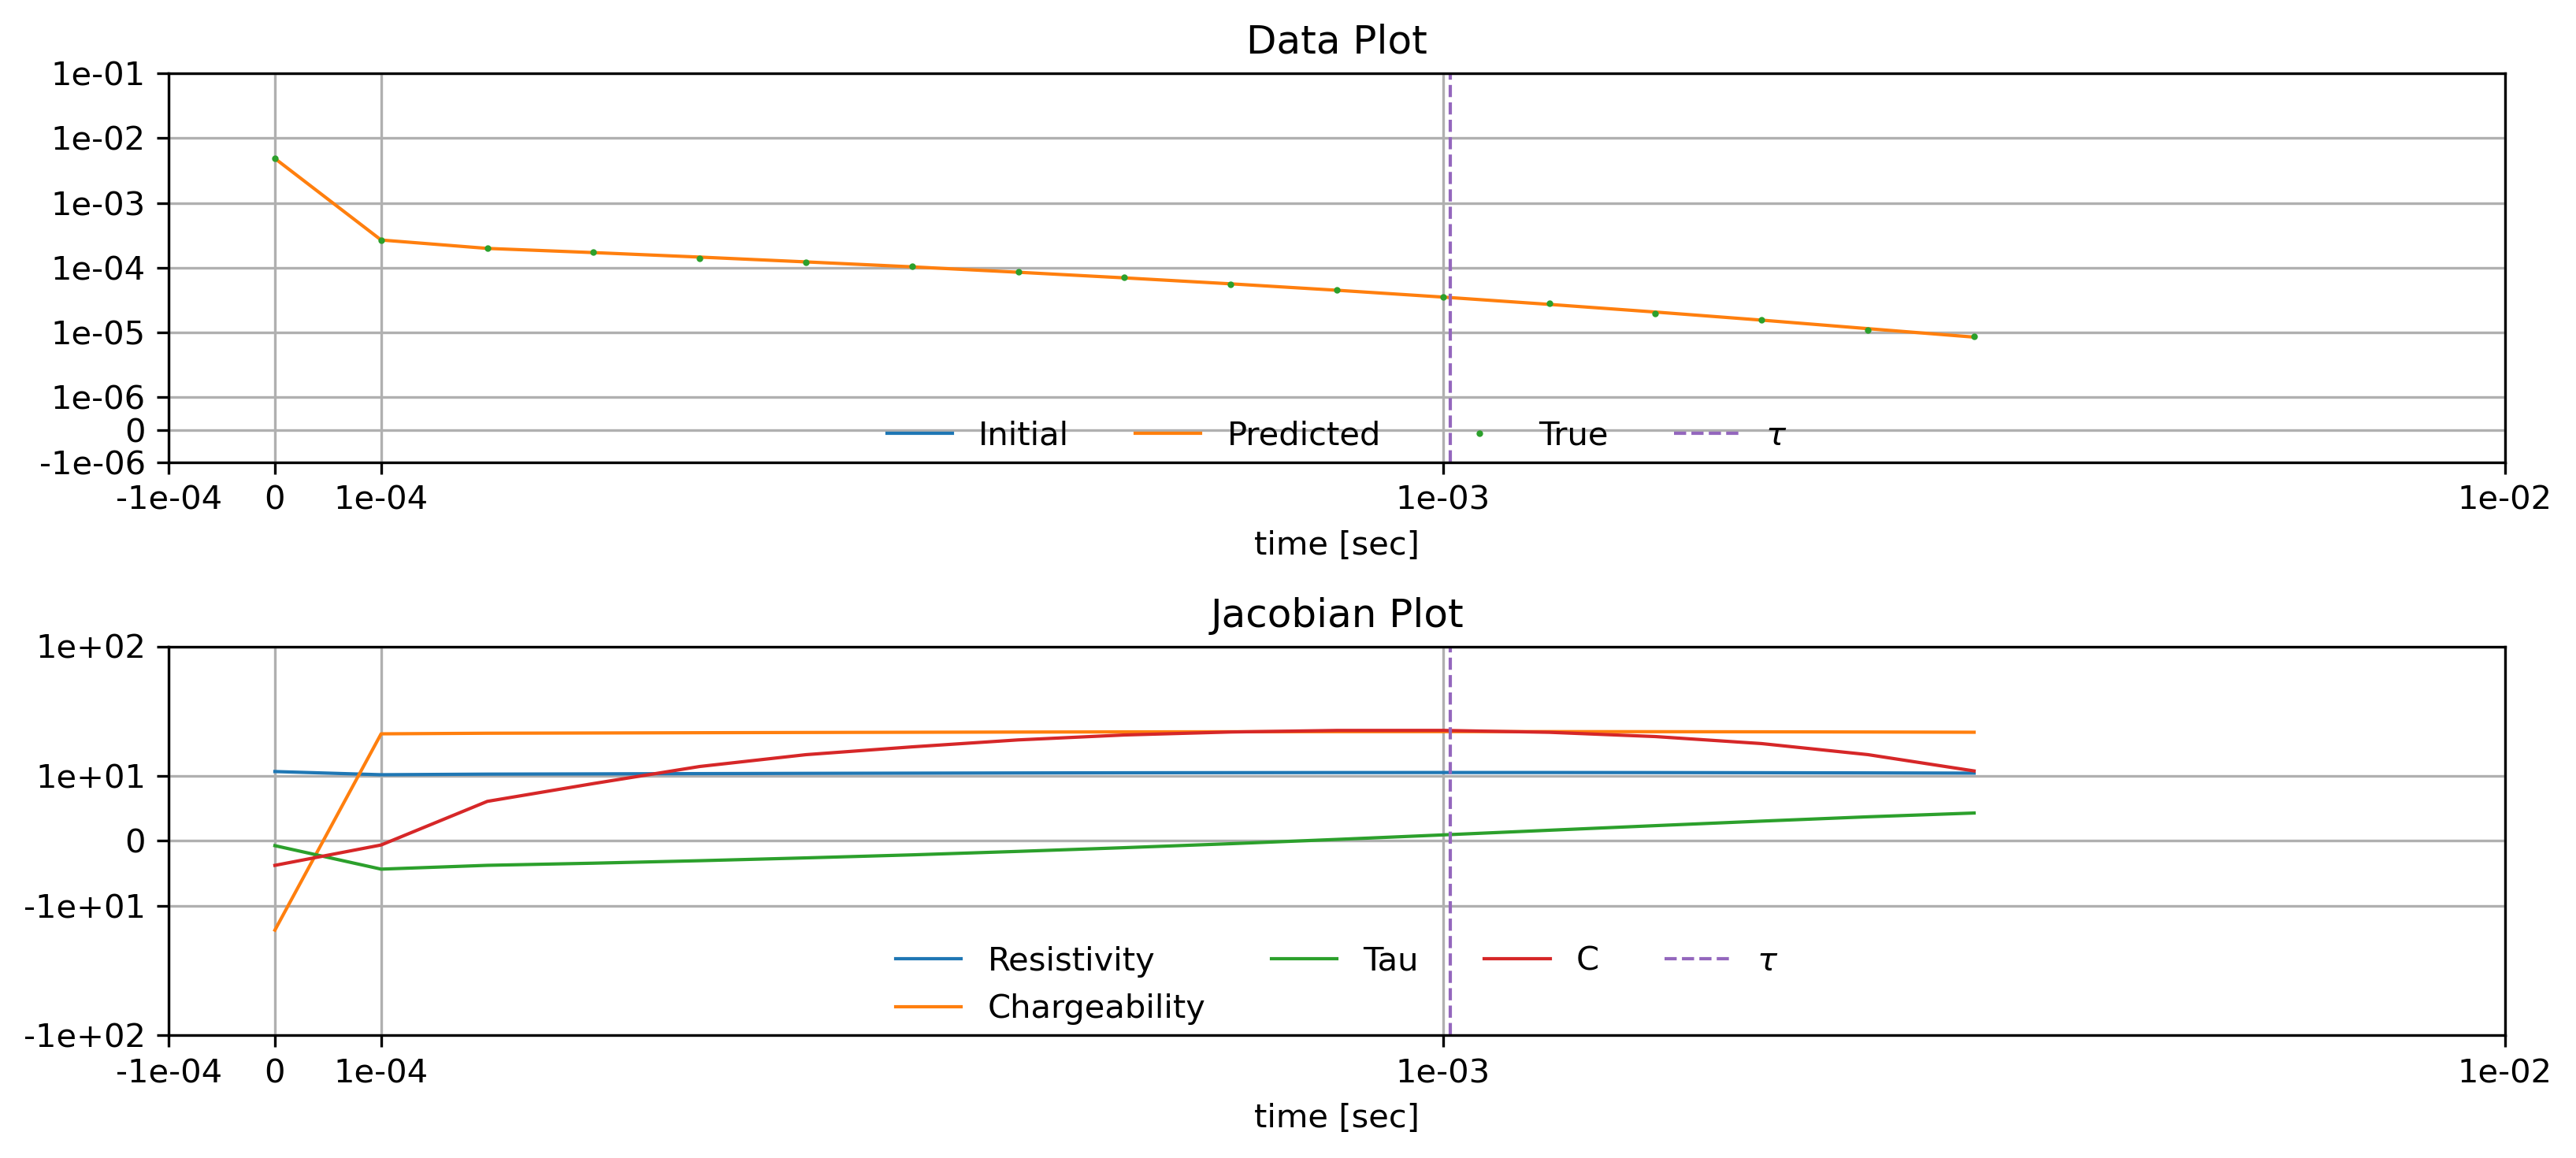

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0] = PL_pelton.plpl_plot(x=windows_plot[0], y=dinit_plot[0], ax=ax[0],
                          color = "C0",label="Initial")
ax[0] = PL_pelton.plpl_plot(x=windows_plot, y=dest_plot, ax=ax[0],
                            color = "C1",label="Predicted")
ax[0] = PL_pelton.plpl_plot(x=windows_plot, y=dobs_plot, ax=ax[0], 
                            color = "C2",linestyle="", marker="o",label="True")
ax[0] = PL_pelton.pl_axvline(ax=ax[0], x=tau_plot, color="C4",label=r'$\tau$')
PL_pelton.pl_axes_x(ax=ax[0])
PL_pelton.pl_axes(ax=ax[0])

ax[1] = PL_jac.plpl_plot(x=windows_plot, y=j_plot[:,0], ax=ax[1],
                                color = "C0",label="Resistivity")
ax[1] = PL_jac.plpl_plot(x=windows_plot, y=j_plot[:,1], ax=ax[1],
                                color = "C1",label="Chargeability")
ax[1] = PL_jac.plpl_plot(x=windows_plot, y=j_plot[:,2], ax=ax[1],
                                color = "C2",label="Tau")
ax[1] = PL_jac.plpl_plot(x=windows_plot, y=j_plot[:,3], ax=ax[1],
                                color = "C3",label="C")
ax[1] = PL_jac.pl_axvline(ax=ax[1], x=tau_plot, color="C4",label=r'$\tau$')
PL_jac.pl_axes_x(ax=ax[1])
PL_jac.pl_axes(ax=ax[1])

for a in ax:
        a.set_xlabel('time [sec]')
#        a.set_ylabel('Amplitude')
        a.grid(which='both')
        # a.legend()
        a.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, frameon=False)
#        plt.tight_layout(rect=[0, 0.1, 1, 1])
ax[0].set_title('Data Plot')
ax[1].set_title('Jacobian Plot')
plt.tight_layout()